![Gold_Price_Prediction_Slide.jpg](attachment:Gold_Price_Prediction_Slide.jpg)

__In this notebook, we are going to build a time series model to predict the future price of gold, which can be very useful for traders. For this purpose, we use the historical gold price data for 10 years (from 2013 to 2023).__

### Let's get started:

# Step 1: Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 2: Reading Dataset

In [ ]:
df = pd.read_csv('/content/gold20231.csv')

# Step 3: Dataset Overview

In [ ]:
df

,Dates,year,day,month,month number,Date,Price,Open,High,Low,Vol.,Change %,close
0,"May 03, 2024",2024,3,May,5,03-05-2024,"2,310.20","2,313.45","2,329.35","2,285.65",-,0.03%,6193.016091
1,"May 02, 2024",2024,2,May,5,02-05-2024,"2,309.60","2,329.90","2,336.10","2,294.30",193.66K,-0.06%,6191.407655
2,"May 01, 2024",2024,1,May,5,01-05-2024,"2,311.00","2,298.20","2,339.50","2,291.70",227.38K,0.35%,6195.160673
3,"Apr 30, 2024",2024,30,Apr,4,30-04-2024,"2,302.90","2,347.00","2,347.60","2,296.20",229.06K,-2.32%,6173.446783
4,"Apr 29, 2024",2024,29,Apr,4,29-04-2024,"2,357.70","2,347.60","2,358.90","2,331.00",187.31K,0.97%,6320.350636
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3641,"Apr 09, 2010",2010,9,Apr,4,09-04-2010,"1,161.90","1,151.80","1,165.80","1,150.40",134.64K,0.78%,3114.736991
3642,"Apr 08, 2010",2010,8,Apr,4,08-04-2010,"1,152.90","1,150.20","1,154.70","1,144.40",119.68K,-0.01%,3090.610446
3643,"Apr 07, 2010",2010,7,Apr,4,07-04-2010,"1,153.00","1,135.20","1,154.20","1,133.30",163.44K,1.50%,3090.878518
3644,"Apr 06, 2010",2010,6,Apr,4,06-04-2010,"1,136.00","1,131.90","1,139.60","1,123.50",126.66K,0.19%,3045.306155


__As you can see, the data set includes daily gold price information including daily Open, High and Low prices and the final price of each day (Price) along with the volume of transactions and price changes in each day.__

__Dataset Basic Information:__

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3646 entries, 0 to 3645
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Dates         3646 non-null   object 
 1   year          3646 non-null   int64  
 2   day           3646 non-null   int64  
 3   month         3646 non-null   object 
 4   month number  3646 non-null   int64  
 5   Date          3646 non-null   object 
 6   Price         3646 non-null   object 
 7   Open          3646 non-null   object 
 8   High          3646 non-null   object 
 9   Low           3646 non-null   object 
 10  Vol.          3646 non-null   object 
 11  Change %      3646 non-null   object 
 12  close         3646 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 370.4+ KB


__All variables are stored as object.__

# Step 4: Data Preparation

## Step 4.1: Feature Subset Selection
__Since we will not use Vol. and Change % features to predict Price, we will drop these two features:__

In [ ]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

In [ ]:
import datetime
def str_to_datetime(s):
  split =  s.split('-')
  year , month , day =  int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(day=day,month=month,year=year)
datetime_object =  str_to_datetime('2024-04-29')
datetime_object

datetime.datetime(2024, 4, 29, 0, 0)

## Step 4.2: Transforming Data

__Date feature is stored as object in the data frame. To increase the speed of calculations, we convert it's data type to datetime and then sort this feature in ascending order:__

In [ ]:
# Change the format of the dates in the 'Date' column to '%m-%d-%Y'
df['Date'] = df['Date'].apply(lambda x: datetime.datetime.strptime(x, '%d-%m-%Y').strftime('%m-%d-%Y'))

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by the 'Date' column
df.sort_values(by='Date', ascending=True, inplace=True)

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

__The " , " sign is redundant in the dataset. First, we remove it from the entire dataset and then change the data type of the numerical variables to float:__

In [ ]:
import datetime
def str_to_datetime(s):
  split =  s.split('-')
  year , month , day =  int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(day=day,month=month,year=year)
datetime_object =  str_to_datetime('2024-04-29')
datetime_object

datetime.datetime(2024, 4, 29, 0, 0)

__Result:__

In [ ]:
df.head()

,Dates,year,day,month,month number,Date,Price,Open,High,Low,Vol.,Change %,close
0,"Apr 05, 2010",2010,5,Apr,4,2010-04-05,"1,133.80","1,122.00","1,134.30","1,120.80",75.64K,0.68%,3039.408555
1,"Apr 06, 2010",2010,6,Apr,4,2010-04-06,"1,136.00","1,131.90","1,139.60","1,123.50",126.66K,0.19%,3045.306155
2,"Apr 07, 2010",2010,7,Apr,4,2010-04-07,"1,153.00","1,135.20","1,154.20","1,133.30",163.44K,1.50%,3090.878518
3,"Apr 08, 2010",2010,8,Apr,4,2010-04-08,"1,152.90","1,150.20","1,154.70","1,144.40",119.68K,-0.01%,3090.610446
4,"Apr 09, 2010",2010,9,Apr,4,2010-04-09,"1,161.90","1,151.80","1,165.80","1,150.40",134.64K,0.78%,3114.736991


## Step 4.3: Checking Duplicates
__There are no duplicate samples in Date feature:__

In [ ]:
df.duplicated().sum()

0

## Step 4.4: Checking Missing Values
__There are no missing values in the dataset:__

In [ ]:
df.isnull().sum().sum()

0

# Step 5: Visualizing Gold Price History Data

__Interactive Gold Price Chart:__

In [ ]:
fig = px.line(y=df.close, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

# Step 6: Splitting Data to Training & Test Sets
__Since we cannot train on future data in time series data, we should not divide the time series data randomly. In time series splitting, testing set is always later than training set. We consider the last year for testing and everything else for training:__

In [ ]:
test_size = df[df.Date.dt.year==2023].shape[0]
test_size

264

__Plot Gold Price Training and Test Sets:__

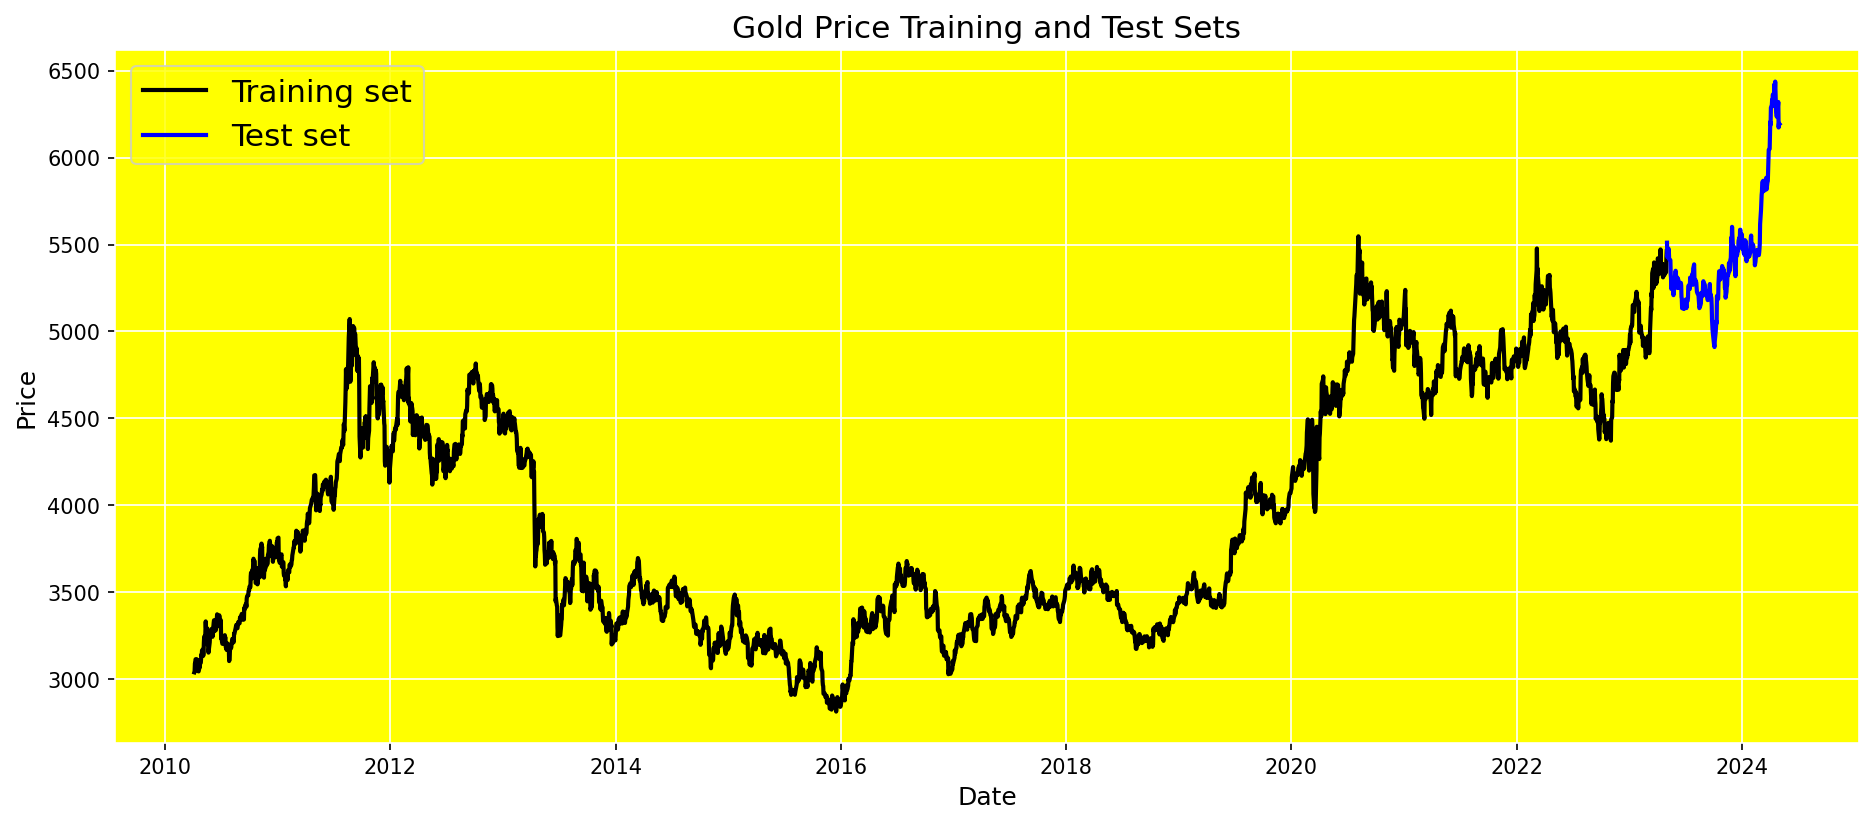

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.close[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.close[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Step 7: Data Scaling
__Since we aim to predict Price only based on its historical data, we scale Price using MinMaxScaler to avoid intensive computations:__

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df.close.values.reshape(-1,1))

MinMaxScaler()

# Step 8: Restructure Data & Create Sliding Window
__The use of prior time steps to predict the next time step is called sliding window. In this way, time series data can be expressed as supervised learning. We can do this by using previous time steps as input variables and use the next time step as the output variable. The number of previous time steps is called the window width. Here we set window width to 60. Therefore, X_train and X_test will be nested lists containing lists of 60 time-stamp prices. y_train and y_test are also lists of gold prices containing the next day's gold price corresponds to each list in X_train and X_test respectively:__

In [ ]:
window_size = 60

__Training Set:__

In [ ]:
train_data = df.close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [ ]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

__Test Set:__

In [ ]:
test_data = df.close[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [ ]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

# Step 9: Converting Data to Numpy Arrays

__Now X_train and X_test are nested lists (two-dimensional lists) and y_train is a one-dimensional list. We need to convert them to numpy arrays with a higher dimension, which is the data format accepted by TensorFlow when training the neural network:__

In [ ]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [ ]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (3322, 60, 1)
y_train Shape:  (3322, 1)
X_test Shape:   (264, 60, 1)
y_test Shape:   (264, 1)


# Step 10: Creating an LSTM Network
__We build an LSTM network, which is a type of Recurrent Neural Networks designed to solve vanishing gradient problem:__

__Model Definition:__

In [ ]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

__Model Training:__

In [ ]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 64)            16896     
                                                                 
 dropout_6 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_7 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0   

# Step 11: Model Evaluation
__Next, we evaluate our time series forecast using MAPE (Mean Absolute Percentage Error) metric:__

In [ ]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

9/9 [==============================] - 2s 44ms/step


In [ ]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [ ]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0005858893855474889
Test MAPE: 0.020023253840978045
Test Accuracy: 0.979976746159022


# Step 12: Visualizing Results

__Returning the actual and predicted Price values to their primary scale:__

In [ ]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

__Investigating the closeness of the prices predicted by the model to the real prices:__

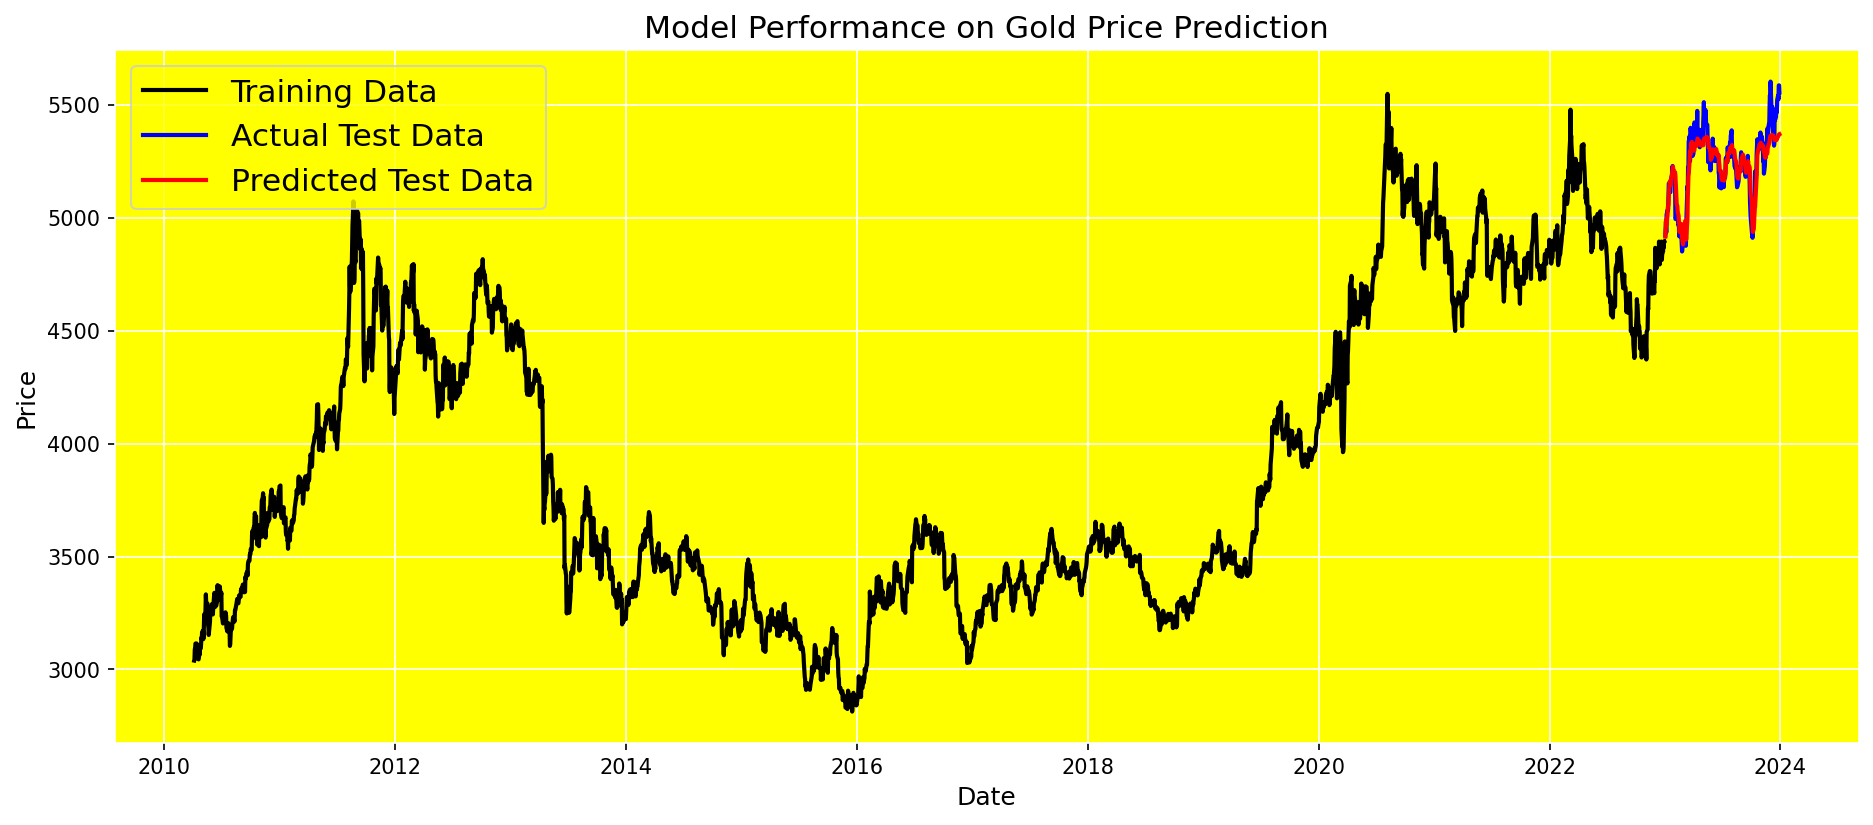

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

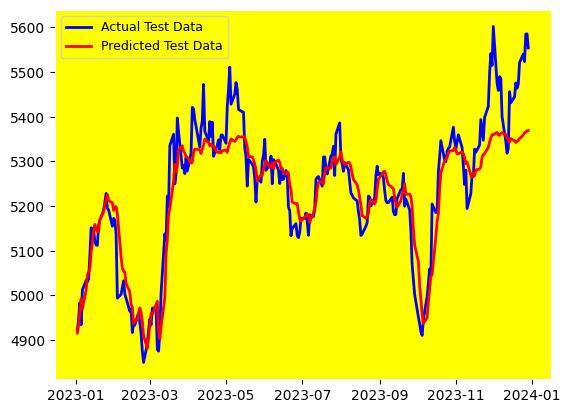

In [ ]:
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.legend(['Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 9})


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_true, y_test_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_true, y_test_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Squared Error (MSE): 4554.8186469555385
Mean Absolute Error (MAE): 49.33835399277937
Root Mean Squared Error (RMSE): 67.489396552018


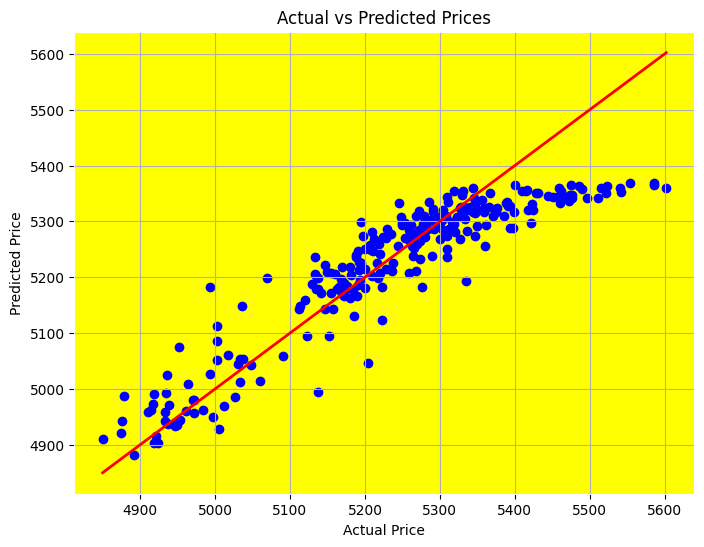

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test_true, y_test_pred, color='blue')
plt.plot([min(y_test_true), max(y_test_true)], [min(y_test_true), max(y_test_true)], color='red', lw=2)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()


In [ ]:
# Assuming X_january_2024 contains your input data for January 2024
# Assuming scaler is the scaler object used during training

# Preprocess the data (e.g., scaling)
X_january_2024_scaled = scaler.transform(X_january_2024)

# Reshape the data to match the input shape expected by the model
X_january_2024_reshaped = X_january_2024_scaled.reshape((1, X_january_2024_scaled.shape[0], 1))

# Use the trained model to make predictions for January 2024
predictions_january_2024_scaled = model.predict(X_january_2024_reshaped)

# Inverse transform the predicted prices to get the actual gold rates
predictions_january_2024 = scaler.inverse_transform(predictions_january_2024_scaled)

# Now 'predictions_january_2024' contains the predicted gold rates for January 2024
print("Predicted gold rates for January 2024:", predictions_january_2024)


NameError: name 'X_january_2024' is not defined

____
# Conclusion:
### As can be seen, the price predicted by the LSTM model follows the actual prices greatly! The value of Loss and Accuracy (1-MAPE) obtained on the test data also confirm the great performance of the model:

## 🏆 Loss: 0.001
## 🏆 Accuracy: 96%

## Best Regards!